## Modelling

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import ipywidgets as widgets
from IPython.display import display
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
import warnings
warnings.filterwarnings('ignore')

In [6]:
df_anime = pd.read_csv("cleaned_data.csv")
#df_anime.drop("Unnamed: 0", axis = 1, inplace = True)
df_anime.head()

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998"
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002"
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005"


In [7]:
!! pip install scikit-learn

['Requirement already satisfied: scikit-learn in c:\\users\\lzdi\\anaconda3\\envs\\learn-env\\lib\\site-packages (0.23.2)',
 'Requirement already satisfied: joblib>=0.11 in c:\\users\\lzdi\\anaconda3\\envs\\learn-env\\lib\\site-packages (from scikit-learn) (0.17.0)',
 'Requirement already satisfied: scipy>=0.19.1 in c:\\users\\lzdi\\anaconda3\\envs\\learn-env\\lib\\site-packages (from scikit-learn) (1.5.0)',
 'Requirement already satisfied: numpy>=1.13.3 in c:\\users\\lzdi\\anaconda3\\envs\\learn-env\\lib\\site-packages (from scikit-learn) (1.23.4)',
 'Requirement already satisfied: threadpoolctl>=2.0.0 in c:\\users\\lzdi\\anaconda3\\envs\\learn-env\\lib\\site-packages (from scikit-learn) (2.1.0)']

In [8]:
df_anime['Synopsis'].isnull().sum()

0

# Metric Based Modelling

## CONTENT BASED MODEL (First Model)

We will first build a content based model by using the ```Synopsis``` and ```Title``` column

In [9]:
df_anime['Synopsis'] = df_anime['Synopsis'].fillna('')

We will use the Term Frequency-Inverse Document Frequency on our model since it is content based.

In [10]:
# creating a sparse matrix for the synopsis column
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(df_anime['Synopsis'])

tfidf_matrix.shape

(12979, 40034)

In [11]:
# finding similar items
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.23529586, 0.02127464, ..., 0.02133734, 0.00457067,
        0.02050118],
       [0.23529586, 1.        , 0.04320112, ..., 0.01628467, 0.01529336,
        0.        ],
       [0.02127464, 0.04320112, 1.        , ..., 0.00264197, 0.        ,
        0.        ],
       ...,
       [0.02133734, 0.01628467, 0.00264197, ..., 1.        , 0.        ,
        0.        ],
       [0.00457067, 0.01529336, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.02050118, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [12]:
#removing duplicate titles
indices = pd.Series(df_anime.index, index=df_anime['Title']).drop_duplicates()
indices

Title
Cowboy Bebop                            0
Cowboy Bebop Tengoku no Tobira          1
Trigun                                  2
Witch Hunter Robin                      3
Bouken Ou Beet                          4
                                    ...  
Animagear                           12974
Magical Halloween MiracleQuartet    12975
Orbital Era                         12976
Akai Hana Shiroi Hana               12977
Arui Tekoteko                       12978
Length: 12979, dtype: int64

In [13]:
# creating a function to give the recommendations
def get_recommendations(title, cosine_sim=cosine_sim):
    
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 15 most similar movies
    sim_scores = sim_scores[1:16]
    
    anime_indices = [i[0] for i in sim_scores]

    return df_anime['Title'].iloc[anime_indices]

In [14]:
# testing our function
get_recommendations('Sen to Chihiro no Kamikakushi')

9604                                      Shounen Maid
560                                 Kujibiki Unbalance
4521                               Suki Desu Suzukikun
5520             Kami nomi zo Shiru Sekai 4nin to Idol
3283                       KerakuNoOH King of Pleasure
10156                              Kushimitama Samurai
5869                                      Sankarea OVA
2422                             ef A Tale of Memories
2816                                         Kiss yori
4199              ef A Tale of Memories  Recollections
11903                                   Mirai no Mirai
740                                         Jyu Oh Sei
2669                                    Hatenkou Yuugi
4822     Ultraman Kids Haha wo Tazunete 3000man Kounen
5113                                Koguma no Korochan
Name: Title, dtype: object

In [15]:
get_recommendations('Koe no Katachi')

12407    Seishun Buta Yarou wa Yumemiru Shoujo no Yume ...
1254                                      Asatte no Houkou
5605                                          Hero Herokun
9159                                     Yuujou no Kickoff
1731                                                  Pops
6486                                          Danchi Tomoo
4730                        Fortune Arterial Akai Yakusoku
12702                               Tomo Tabidachi no Toki
6611                         Kakumeiki Valvrave 2nd Season
6473                                        Harisu no Kaze
8974                         Gakuen Handsome The Animation
10173                                      Gakuen Handsome
10787                                           Tejina Shi
5429                                    VitaminX Addiction
5830                             Yajikita Gakuen Douchuuki
Name: Title, dtype: object

In [65]:
get_recommendations('Bleach')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## CONTENT BASED MODEL(Second Model)

Genres, Producer and Studio Based Recommender It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the producer, related genres and the studio to see if we will get better recommendations

In [16]:
#previewing data again
df_anime.head(2)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"


In [17]:
# extracting the columns that we need
features = ['Genre','Producer', 'Studio']

print(df_anime[features].isnull().sum())

Genre          0
Producer    5779
Studio      5611
dtype: int64


In [18]:
df_anime[features] = df_anime[features].fillna('[' ']')

In [19]:
df_anime.Type.unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music', 'Unknown'],
      dtype=object)

In [20]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ","")) for i in x]
    
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ",""))
        else:
            return ""

In [21]:
features = ['Genre','Producer', 'Studio', 'Type']

for feature in features:
    df_anime[feature] = df_anime[feature].apply(clean_data)

In [22]:
# previewing data
df_anime.head(2)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"['action','adventure','comedy','drama','sci-fi...","In the year 2071, humanity has colonized sever...",tv,['bandaivisual'],['sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"['action','space','drama','mystery','sci-fi']","Another day, another bounty—such is the life o...",movie,"['sunrise','bandaivisual']",['bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"


In [23]:
# preview of features
features

['Genre', 'Producer', 'Studio', 'Type']

In [24]:
# function to join the two dataframes
def create_soup(x):
    return " ".join(x['Genre']) + " " + x['Type'] + " " + " ".join(x['Producer']) + " " + " ".join(x['Studio']) + " " + x['Synopsis'] + " " + " ".join(x['Studio']) 

In [25]:
df_anime['soup'] = df_anime.apply(create_soup, axis=1)

In [26]:
df_anime['soup']

0        [ ' a c t i o n ' , ' a d v e n t u r e ' , ' ...
1        [ ' a c t i o n ' , ' s p a c e ' , ' d r a m ...
2        [ ' a c t i o n ' , ' s c i - f i ' , ' a d v ...
3        [ ' a c t i o n ' , ' m a g i c ' , ' p o l i ...
4        [ ' a d v e n t u r e ' , ' f a n t a s y ' , ...
                               ...                        
12974    [ ' k i d s ' , ' m e c h a ' ] ona [ ] [ ] A ...
12975    [ ' c o m e d y ' , ' e c c h i ' , ' f a n t ...
12976    [ ' a c t i o n ' , ' a d v e n t u r e ' , ' ...
12977    [ ' k i d s ' , ' m u s i c ' ] music [ ] [ ] ...
12978    [ ' k i d s ' , ' m u s i c ' ] music [ ] [ ] ...
Name: soup, Length: 12979, dtype: object

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of a producer if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [27]:
# using a count vectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_anime['soup'])

# calculating cosine similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [28]:
df_anime = df_anime.reset_index()
indices = pd.Series(df_anime.index, index=df_anime['Title'])

In [29]:
indices

Title
Cowboy Bebop                            0
Cowboy Bebop Tengoku no Tobira          1
Trigun                                  2
Witch Hunter Robin                      3
Bouken Ou Beet                          4
                                    ...  
Animagear                           12974
Magical Halloween MiracleQuartet    12975
Orbital Era                         12976
Akai Hana Shiroi Hana               12977
Arui Tekoteko                       12978
Length: 12979, dtype: int64

Now that we have the cosine similarities, we can use the fuction we created earlier to get recommendations.

In [30]:
# testing the function
get_recommendations('Cowboy Bebop', cosine_sim2)

1                      Cowboy Bebop Tengoku no Tobira
3226                             Ginga Senpuu Braiger
11619                                          Hiromi
4563                                              KOn
5950                                   Little Busters
1167                        Sol Bianca Taiyou no Fune
2533     Saraba Uchuu Senkan Yamato Ai no Senshitachi
2411                Code Geass Hangyaku no Lelouch R2
1338                              Uchuu Senkan Yamato
3841                            Uchuu Kuubo Blue Noah
11611                                 Chibikko Cowboy
9948                                       Xiao Yeyou
6238                              Suisei no Gargantia
9016                                Dragon Ball Super
4964                     Rokushin Gattai GodMars 1982
Name: Title, dtype: object

In [31]:
get_recommendations('Sen to Chihiro no Kamikakushi', cosine_sim2)

9604                                        Shounen Maid
740                                           Jyu Oh Sei
10156                                Kushimitama Samurai
2669                                      Hatenkou Yuugi
11903                                     Mirai no Mirai
6115                      Majokko Shimai no Yoyo to Nene
560                                   Kujibiki Unbalance
5113                                  Koguma no Korochan
6438           Ashita Genki ni Nare Hanbun no Satsumaimo
7374     Kero Kero Keroppi no Yowamushiouji no Daibouken
92                               Chou Henshin Cosprayers
3124                                    Net Ghost Pipopa
5911                            Kyoto Animation Hoshihen
999               Fushigi no Umi no Nadia Original Movie
10684      Death March kara Hajimaru Isekai Kyousoukyoku
Name: Title, dtype: object

In [32]:
get_recommendations('Mirai no Mirai', cosine_sim2)

3478                             Umineko no Naku Koro ni
3809                                   Suteneko Torachan
9493                    Tenchi Muyou Ryououki 4th Season
8395                                           Hand Soap
4233                           Doubutsu Mura no Daisodou
2269                                       Umi no Triton
8323     Kyoukai no Kanata Movie 2 Ill Be Here  Miraihen
6529                                         Golden Time
10858                             Haruniwa Ie no 3 Ninme
5123                                               Oshin
3584                                     Minamike Okaeri
6035                           Kono Sekai no Katasumi ni
11288                                        Yao Shen Ji
298                            Mama wa Shougaku 4 Nensei
2993                                     Chis Sweet Home
Name: Title, dtype: object

In [33]:
display(df_anime[['Title', 'Rating', 'Producer', 'Studio']].loc[df_anime['Title'] == 'Sen to Chihiro no Kamikakushi'])

,Title,Rating,Producer,Studio
178,Sen to Chihiro no Kamikakushi,8.92,['toho'],['studioghibli']


Our earlier model gives better recommendations in the context where we use ```Cowboy Bebop``` title as an example. The first function gives more recommendations of titles about ```Cowboy Bebop``` than the second model.

# COLLABORATIVE FILTERING

## Preprocessing for Collaborative Filtering

In [34]:
# renaming the anime_id col
df_anime = df_anime.rename(columns={'MAL_ID':'anime_id'})

In [35]:
#looking at the shape
df_anime.shape

(12979, 16)

In [38]:
#loading the cleaned ratings data
rating = pd.read_csv('rating.csv')
#rating.drop("Unnamed: 0", axis = 1, inplace = True)
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [39]:
# confirming there are no duplicates
duplicates=rating.duplicated()
if duplicates.sum()>0:
    print('>{} duplicates'.format(duplicates.sum()))
    rating=rating[~duplicates]
    
print('>{} duplicates'.format(rating.duplicated().sum()))

>1 duplicates
>0 duplicates


In [40]:
# checking the entries
rating.shape

(7813736, 3)

In [41]:
# finding unique users and items
unique_users = {int(x): i for i,x in enumerate(rating.user_id.unique())}
unique_items = {int(x): i for i,x in enumerate(rating.anime_id.unique())}

print(" No. of unique anime:",len(unique_items),'\n',"No. of Unique users ", len(unique_users))

 No. of unique anime: 11200 
 No. of Unique users  73515


In [42]:
# more wrangling
n_rating=rating['user_id'].value_counts()
rating=rating[rating['user_id'].isin(n_rating[n_rating>=500].index)].copy()

In [43]:
rating.shape

(1384631, 3)

In [44]:
# preview of the ratings 
rating.head()

,user_id,anime_id,rating
1614,17,6,7
1615,17,19,10
1616,17,30,9
1617,17,32,10
1618,17,43,8


### Distribution of ratings
  

* We will now investigate the distribution of ratings on both the datasets

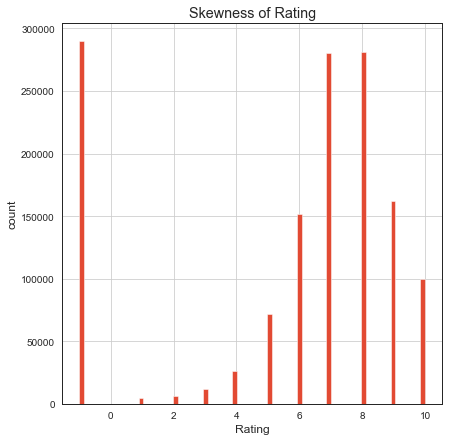

In [45]:
    # ploting the skewness
    
    plt.figure(figsize = (15, 7))
    plt.subplot(1,2,1)
    rating["rating"].hist(bins=70)
    plt.xlabel("Rating")
    plt.ylabel("count")
    plt.title("Skewness of Rating")
    plt.show()

In [46]:
# picking numeric columns
new_data = df_anime[['Anime_id','Title', 'ScoredBy',"Members", 'Rating']]

In [47]:
# renaming some columns
rating=rating.rename(columns={'anime_id':'Anime_id'})

In [48]:
# merging the the two dataframes for modelling
new_data=pd.merge(new_data,rating,on='Anime_id')

In [49]:
new_data=new_data.sort_values(by='ScoredBy', ascending=False).query('Members>500')

In [50]:
new_data=new_data.sort_values(by='ScoredBy', ascending=False).query('Members>500')

In [51]:
new_data.shape

(1206012, 7)

In [52]:
total=new_data.isnull().sum().sort_values(ascending=False)
percent=(new_data.isnull().sum()/new_data.isnull().count()).sort_values(ascending=False)
print(percent)

Title       0.000002
rating      0.000000
user_id     0.000000
Rating      0.000000
Members     0.000000
ScoredBy    0.000000
Anime_id    0.000000
dtype: float64


### Pivot Table
We will now create a pivot table so as to make the modelling work much easier

In [53]:
anime_pivot=new_data.pivot_table(index='Title',columns='user_id',values='rating').fillna(0)

In [54]:
anime_pivot.head()

user_id,17,54,201,226,271,294,342,392,446,478,661,741,771,786,804,917,940,958,1019,1103,1145,1176,1191,1287,1338,1344,1456,1497,1504,1522,1530,1579,1720,1822,1870,1984,2200,2243,2264,2273,2297,2378,2632,2695,2701,2810,2820,2864,2951,3009,3040,3117,3124,3127,3193,3203,3325,3338,3391,3476,3500,3557,3569,3573,3597,3615,3657,3695,4064,4102,4168,4177,4215,4350,4468,4512,4749,4759,4814,4834,4842,4843,4883,4948,4979,4987,4988,5053,5056,5073,5076,5137,5148,5244,5249,5264,5296,5310,5311,5325,5335,5357,5374,5394,5421,5428,5492,5504,5516,5526,5555,5562,5584,5598,5655,5669,5672,5680,5705,5720,5732,5770,5815,5831,5838,5886,5895,5899,5908,5950,5954,6014,6111,6118,6125,6152,6162,6164,6237,6265,6268,6321,6361,6381,6384,6392,6417,6434,6469,6474,6509,6525,6542,6569,6583,6589,6618,6695,6769,6770,6771,6773,6814,6836,6869,6893,6922,6925,6932,6969,6971,7080,7081,7114,7172,7247,7249,7297,7311,7340,7345,7350,7366,7421,7440,7446,7458,7511,7520,7533,7600,7622,7648,7659,7669,7670,7672,7674,7711,7715,7716,7726,7728,7755,7777,7802,7821,7824,7852,7896,7904,7988,8006,8031,8058,8087,8093,8094,8095,8103,8107,8115,8122,8128,8144,8149,8200,8215,8217,8221,8226,8231,8287,8308,8421,8425,8446,8494,8820,9032,9752,9995,10072,10146,10194,10231,10240,10283,10297,10298,...,60352,60365,60375,60390,60407,60440,60524,60537,60590,60675,60711,60721,60743,60791,60798,60917,60918,60932,60975,60978,60985,60986,61007,61024,61060,61065,61110,61130,61149,61163,61188,61189,61210,61254,61329,61338,61344,61349,61368,61389,61409,61443,61484,61488,61504,61529,61547,61561,61622,61651,61678,61682,61767,61831,61842,61932,62082,62209,62237,62266,62309,62469,62480,62681,62830,63121,63157,63202,63710,64126,64174,64242,64354,64372,64542,64623,64636,64664,65108,65152,65175,65237,65276,65287,65382,65420,65468,65557,65588,65595,65682,65723,65728,65755,65809,65836,65840,65844,65855,65856,65875,65944,65993,66004,66021,66024,66049,66087,66105,66118,66133,66142,66355,66390,66449,66492,66510,66551,66561,66563,66569,66650,66700,66731,66742,66755,66816,66863,66885,66989,67006,67043,67050,67082,67099,67117,67214,67239,67244,67286,67296,67348,67372,67378,67386,67451,67478,67487,67493,67509,67566,67627,67629,67635,67661,67666,67671,67701,67708,67725,67749,67762,67844,67852,67866,67871,67910,67946,67975,67981,68017,68084,68091,68148,68171,68203,68243,68465,68473,68522,68559,68633,68721,68725,68762,68787,68795,68797,68925,68939,69037,69076,69121,69341,69394,69514,69596,69964,70015,70053,70161,70201,70433,70507,70585,70725,70953,71057,71278,71284,71302,71362,71456,71491,71537,71610,71655,71790,71792,71804,71893,72054,72060,72200,72646,72794,72814,72851,72936,72997,73075,73114,73128,73132,73135,73159,73162,73177,73188,73234,73272,73286,73340,73356,73362,73378,73395,73408,73499,73502
Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Now that our data is ready for modelling, we will use the item based collaborative filtering model to get recommendations.

### Item Based

In [55]:
# generating a sparse matrix from our pivot table
anime_matrix = csr_matrix(anime_pivot.values)

# initializing a base model
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(anime_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [56]:
query_index = np.random.choice(anime_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(anime_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

1086


In [57]:
# creating a recommendation function
def get_rec(name,it):
    distances, indices = model_knn.kneighbors(anime_pivot.loc[name].values.reshape(1, -1), n_neighbors = 250+it)
    d1=pd.DataFrame(columns=df_anime.columns)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for',name)
        else:
            d2=df_anime.loc[df_anime["Title"]==anime_pivot.index[indices.flatten()[i]]]
            d1=d1.append(d2)
    return d1[["Title","ScoredBy"]].sort_values(by="ScoredBy",ascending=False)[:it]

In [58]:
# testing our function
get_rec('Shingeki no Kyojin',15)

Recommendations for Shingeki no Kyojin


,Title,ScoredBy
1239,Death Note,1006242.0
5682,Sword Art Online,913806.0
3567,Fullmetal Alchemist Brotherhood,730784.0
8859,One Punch Man,687965.0
7300,Tokyo Ghoul,656039.0
10,Naruto,645672.0
4121,Angel Beats,640177.0
1274,Code Geass Hangyaku no Lelouch,625466.0
6891,No Game No Life,620456.0
5435,Mirai Nikki,591121.0


In [59]:
get_rec('Fullmetal Alchemist Brotherhood',15)

Recommendations for Fullmetal Alchemist Brotherhood


,Title,ScoredBy
1239,Death Note,1006242.0
6232,Shingeki no Kyojin,936784.0
5682,Sword Art Online,913806.0
8859,One Punch Man,687965.0
7300,Tokyo Ghoul,656039.0
10,Naruto,645672.0
4121,Angel Beats,640177.0
1274,Code Geass Hangyaku no Lelouch,625466.0
6891,No Game No Life,620456.0
5435,Mirai Nikki,591121.0


In [60]:
get_rec('Doraemon Movie 07 Nobita to Tetsujin Heidan',10)

Recommendations for Doraemon Movie 07 Nobita to Tetsujin Heidan


,Title,ScoredBy
9863,Dungeon ni Deai wo Motomeru no wa Machigatteir...,29421.0
2005,Digimon Adventure Bokura no War Game,29173.0
667,Digimon Savers,28566.0
1356,Bakuten Shoot Beyblade 2002,22666.0
2006,Digimon Adventure 02 Diablomon no Gyakushuu,21737.0
898,Medarot,21122.0
2447,Digimon Adventure 02 Movies,18619.0
1355,Bakuten Shoot Beyblade G Revolution,17211.0
9306,To LOVERu Darkness 2nd OVA,16698.0
1993,One Piece Jango no Dance Carnival,14493.0


In [61]:
get_rec('Naruto',10)

Recommendations for Naruto


,Title,ScoredBy
1239,Death Note,1006242.0
6232,Shingeki no Kyojin,936784.0
5682,Sword Art Online,913806.0
3567,Fullmetal Alchemist Brotherhood,730784.0
8859,One Punch Man,687965.0
7300,Tokyo Ghoul,656039.0
4121,Angel Beats,640177.0
1274,Code Geass Hangyaku no Lelouch,625466.0
6891,No Game No Life,620456.0
5435,Mirai Nikki,591121.0


In [62]:
# saving our function
import pickle
filename='KNN_model_forCF.sav'
pickle.dump(model_knn,open(filename,'wb'))

In [64]:
get_rec('Bleach',10)

Recommendations for Bleach


,Title,ScoredBy
1239,Death Note,1006242.0
6232,Shingeki no Kyojin,936784.0
5682,Sword Art Online,913806.0
3567,Fullmetal Alchemist Brotherhood,730784.0
8859,One Punch Man,687965.0
7300,Tokyo Ghoul,656039.0
10,Naruto,645672.0
4121,Angel Beats,640177.0
1274,Code Geass Hangyaku no Lelouch,625466.0
6891,No Game No Life,620456.0


# HYBRID RECOMMENDATION 

We will now build a hybrid recommendation system to get recommendations

In [66]:
data = pd.read_csv('cleaned_data.csv')
#data.drop('Unnamed: 0', axis = 1, inplace = True)
data.dropna(subset = ['Title'], inplace = True)
data.head()

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998"
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002"
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005"


We will then use a Term frequency - inverse document frequency to create a search engine so that it is easy to find an anime title and its anime id. The tfdif will enable the computer to find the title that is most similar to the title that we will enter.

In [67]:
# vector matrix for the anime titles

# finding groups of 2 words that are consecutive
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(data["Title"])

We will then create a function that will use cosine similarity to compute the similarity between a term that we will enter in our search box and all the anime titles in our dataset.

In [87]:

# creating a search function 
def search(title):
    """
    A function that takes in a search term of the title that we are 
    looking for then cleans it and uses the vectorizer
    to turn it into a sparse matrix and then uses cosine similarity to find the
    most similar titles.
    """
    # cleaning the title entered
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()

    # find the 5 most similar titles to the searcch term
    indices = np.argpartition(similarity, -5)[-10:]

    # reverse results so that most similar result is at the top
    results = data.iloc[indices].iloc[::-1]
    
    return results['Title'].to_list()

In [88]:
with open('search.pkl','wb') as f:
    pickle.dump(search,f)

In [89]:
search('dragon ball')

['Dragon Ball',
 'Dragon Ball Kai',
 'Dragon Ball Specials',
 'Dragon Ball Super',
 'Dragon Ball GT',
 'Dragon Ball Z The Real 4D',
 'Dragon Ball Z Zenbu Misemasu Toshi Wasure Dragon Ball Z',
 'Dragon Ball Z Saiyajin Zetsumetsu Keikaku',
 'Dragon Ball Super Movie Broly',
 'Dragon Ball Episode of Bardock']

We will use the widgets library to build an interactive search box using our function above. The search box will enable one to type in the name of an anime and see the results.

In [ ]:
# using the widgets library
movie_input = widgets.Text(
    # setting default value as Trigun
    value='Trigun',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]

        # display output when length of title is more than 5
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

We will hardcode an anime id for the 'Cowoy Bebop' anime to find the users who watched and also liked same anime and gave it a rating greater than 6.

In [ ]:
# hard coding an anime id to find the users who liked the same movie
movie_id = 1

#def find_similar_movies(movie_id):
anime = data[data["Anime_id"] == movie_id]

We  will now use the ratings dataset to find the users who liked the same movie.

In [ ]:
# loadind the clean rating data
ratings = pd.read_csv('cleaned_rating.csv')
ratings.drop("Unnamed: 0", axis = 1, inplace = True)
ratings.head()

In [ ]:
# finding similar users
similar_users = ratings[(ratings["anime_id"] == movie_id) & (ratings["rating"] > 6)]["user_id"].unique()
similar_users

We will then put it into a dataframe to return the records of the similar users.

In [ ]:
# similar users dataframe
similar_user_recs = ratings[(ratings["user_id"].isin(similar_users)) & (ratings["rating"] > 6)]
similar_user_recs

In [ ]:
# getting the anime ids from the dataframe
similar_user_recs = ratings[(ratings["user_id"].isin(similar_users)) & (ratings["rating"] > 6)]["anime_id"]
similar_user_recs

We will then narrow down the dataframe so that we only get 10% or more of users who are similar and also liked the same movie

In [ ]:
# get value counts for the movie ids
similar_user_recs.value_counts()

In [ ]:
# Converting to percentage
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

# Taking records where only greater than 10% liked
similar_user_recs = similar_user_recs[similar_user_recs > .10]
similar_user_recs

We now have a set of 326 animes where more than 10% of users liked the anime title. We will now find users who liked animes that are similar to the 'Cowboy' anime. This will be done by finding the users who have rated the animes in our 'similar_user_recs'.

In [ ]:
# finding how much all users in the dataset like the animes
all_users = ratings[(ratings["anime_id"].isin(similar_user_recs.index)) & (ratings["rating"] > 6)]
all_users

We will then find the percentage of all users who recommended the animes that are in ``similar_user_recs``.

In [ ]:
# calculating percentage
all_user_recs = all_users["anime_id"].value_counts() / len(all_users["user_id"].unique())
all_user_recs

We will then compare the percentages in ```similar_user_recs``` and ```all_users_recs``` by joining the two pandas series so as to see how users similar to us liked the anime and how much an average person liked the same animes.

The goal is to find the animes that have a big difference.

In [ ]:
# joining the two pandas series
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages

We will then calculate a score by dividing one percentage by the other.

In [ ]:
# finding the ratio between the percentages
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]

# sorting the recommendations based on the scores
rec_percentages = rec_percentages.sort_values("score", ascending=False)
rec_percentages

From the above dataframe, the higher the score, the better the recommendation.

We will then get the top 10 recommendations and merge that with our ```anime``` dataset so as to get the title of the movies.

In [ ]:
# getting top 10 recommendations
rec_percentages.head(10).merge(data, left_index=True, right_on="Anime_id")

We will then put all the code above into one function.

In [ ]:
def find_similar_movies(movie_id):
    
    # finding recommendations for users that are similar 
    similar_users = ratings[(ratings["anime_id"] == movie_id) & (ratings["rating"] > 6)]["user_id"].unique()
    similar_user_recs = ratings[(ratings["user_id"].isin(similar_users)) & (ratings["rating"] > 6)]["anime_id"]

    # narrowing them down to 10%
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    similar_user_recs = similar_user_recs[similar_user_recs > .10]

    # finding how common the recommendations are among all users
    all_users = ratings[(ratings["anime_id"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["anime_id"].value_counts() / len(all_users["user_id"].unique())

    # concatenating all_user_recs and similar_user_recs
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    
    # calculating the score
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    # sorting values based on score
    rec_percentages = rec_percentages.sort_values("score", ascending=False)

    # return the top 10 recommendations
    return rec_percentages.head(10).merge(data, left_index=True, right_on="Anime_id")[["score", "Title", "Genre"]]

We will now create an interactive recommendation widget where one gets to type in an anime title and get recommendations based on the anime title

In [ ]:
# creating an input widget
movie_name_input = widgets.Text(
    value='Trigun',
    description='Movie Title:',
    disabled=False
)

# creating an output widget
recommendation_list = widgets.Output()

# creating an ontype function
def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()

        # grab title from input widget
        title = data["new"]

        # display output when length of title is more than 5
        if len(title) > 5:
            # search title using the search function
            results = search(title)
            movie_id = results.iloc[0]["Anime_id"]
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')

display(movie_name_input, recommendation_list)

# Model Based Modelling

In this section, we will use the knnwithmeans and SVD algorithms to build our recommendation model.

In [ ]:
# reloading and preview of data
new_df = pd.read_csv("cleaned_anime.csv")
new_df.dropna(subset = ['Title'], inplace = True)
new_df = df_anime[['Anime_id', 'Title', 'Rating']]
new_df

In [ ]:
#Loading the data set
reader = Reader()
data = Dataset.load_from_df(new_df,reader)

In [ ]:
# Print the number of users and items
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

In [ ]:
# Split the data into train and test set
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Print the number of users and items
print('Number of users_train: ', trainset.n_users, '\n')
print('Number of items_train: ', trainset.n_items, '\n')

In [ ]:
# creating a class to get the top users
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
#function to use for collaborative Filtering 
class collab_filtering_based_recommender_model():
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

    def fit_and_predict(self):        
        print('**Fitting the train data...**')
        self.model.fit(self.trainset)       

        print('**Predicting the test data...**')
        self.pred_test = self.model.test(self.testset)        
        rmse = round(accuracy.rmse(self.pred_test), 3)
        print('**RMSE for the predicted result is ' + str(rmse) + '**')   
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns=['CustomerID', 'Description', 'rating'])
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['Description', 'rating'])
            subdf['CustomerID'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]        
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
        return rmse
        
    def cross_validate(self):
        print('**Cross Validating the data...**')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1)
        cv_result = round(cv_result['test_rmse'].mean(),3)
        print('**Mean CV RMSE is ' + str(cv_result)  + '**')
        return cv_result

In [ ]:
# Finding the best collaborative Filtering model
from surprise.model_selection import RandomizedSearchCV

def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

In [ ]:
# finding the best model between cosine, pearson and pearson_baseline
sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, data)

We have an RMSE of 1.7. We will go ahead and fit another model using our collaborative filtering function above to see if we get better results

In [ ]:
#fit knnwithmeans model
knnwithmeans = clf.best_estimator['rmse']
col_fil_knnwithmeans = collab_filtering_based_recommender_model(knnwithmeans, trainset, testset, data)

In [ ]:
#fit and predict using the knnmeans model
knnwithmeans_rmse = col_fil_knnwithmeans.fit_and_predict()

The rmse does not change much therefore we will go ahead and cross validate our model to see if we have rmse

In [ ]:
#cross validate using knnwith means
knnwithmeans_cv_rmse = col_fil_knnwithmeans.cross_validate()

The rmse still does not change much therefore we will use the SVD algorithm to build another model and then cross validate it to see if we have better results

In [ ]:
#fitting the SVD model
params= {
    "n_epochs": [5, 10, 15, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
clf = find_best_model(SVD, params, data)

In [ ]:
#fitting the SVD model to the train and test data
svd = clf.best_estimator['rmse']
col_fil_svd = collab_filtering_based_recommender_model(svd, trainset, testset, data)

In [ ]:
#fitting and prediciting the SVD model
svd_rmse = col_fil_svd.fit_and_predict()

In [ ]:
#cross validate using SVD
svd_cv_rmse = col_fil_svd.cross_validate()

In [ ]:
cross_validate(svd,data,measures=['RMSE', 'MAE'], cv=5, verbose=True)

# EVALAUTION

We have built 2 types of recommendation model;
* Metric based
* Model based.

For the metric based model, we have the content-based and the hybrid model. The hybrid model gave better recommendations than than the content-based model.

For the Model based, we have used the ```SVD``` and ```knnwithmeans``` algorithms. Both models perform almost the same hence we opted to go with either of the model since they both satisfy our objective of attaining an RMSE of 2.0 and below.

In [ ]:
Models=['SVD', 'KNNWithMeans']

In [ ]:
# creating a dataframe to compare the algorithms
pd.DataFrame({'model':['SVD', 'KNNWithMeans'],'RMSE':[svd_cv_rmse,knnwithmeans_cv_rmse]})

# DEPLOYMENT

We deployed the hybrid model on streamlit where the app prompts a user to select a title. After selecting the title, the user is given the top 10 recommendations.
    
 * One can use the model through the following [Link](https://anime-deployment.streamlit.app/)

# RECOMMENDATIONS

* This app is beneficial to the anime lovers and anime producers.
* The recommendation system can be improved by using GridSearch cv. Grid search requires a lot of computational power therefore it is recommended that you have enough computational power so as to do a Grid search.